In [148]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer,logging
import matplotlib
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import Occlusion
import time
import pickle
from tqdm import tqdm
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import collections

nlp = spacy.load('en_core_web_trf')
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model and set seed

In [150]:
# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

class BERT(nn.Module):
    def __init__(self, bert):
        
        super(BERT, self).__init__()
        
        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 512)
        # Linear II (Out)
        #self.fc2 = nn.Linear(512, 170)
        self.fc2 = nn.Linear(512, 817)

        
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)


    # Forward pass
    def forward(self, **kwargs):

        # Pass data trough bert and extract 
        cls_hs = self.bert(**kwargs)
        # Extract hidden state
        hidden_state = cls_hs.last_hidden_state
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        
        # Dense layer 1        
        x = self.fc1(pooler)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc2(x)
        # Activation
        x = self.softmax(x)

        return x
    
# Load the entire model
model = BERT(bert)

# Load trained model (colab)
try:
    try:
        model_save_name = 'saved_weights_PartialDescriptions817.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}"
        model.load_state_dict(torch.load(path))
        print('Google Success')

    except:
        model_save_name = 'saved_weights_PartialDescriptions817.pt'
        path = "../models/" + model_save_name
        model.load_state_dict(torch.load(path, 
                                         map_location=torch.device('cpu')))
        print('Local Success')
except:
    print('No pretrained model found.')
    
model.to(device)
model.eval()
model.zero_grad()

Local Success


In [151]:
# Set seeds
torch.manual_seed(333)
np.random.seed(333)

### Function and tokens

In [152]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [153]:
# Modify the prediction output and define a custom forward
def predict(inputs):
    return model(input_ids=inputs, attention_mask=attention_mask)[0]
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.exp(preds)

In [154]:
# Tokenize functions
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [155]:
# Summarize and vis functions
def summarize_attributions_ig(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def summarize_attributions_occ(attributions):
    return attributions.sum(axis=0)

def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

def colorize(attribution, tokens):
    
    template = """  
    <mark class="entity" style="
    background: {}; 
    padding: 0.4em 0.0em; 
    margin: 0.0em; 
    line-height: 2; 
    border-radius: 0.0em;
    ">{}<span style="
    font-size: 0.8em; 
    font-weight: bold; 
    line-height: 1; 
    border-radius: 0.0em;   
    text-align-last:center;
    vertical-align: middle;
    margin-left: 0rem;
    "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.PiYG).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]': 
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

In [156]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
occ = Occlusion(custom_forward)

## Single Example

In [157]:
text = 'The plant has a purple flower with white petals.'

In [158]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [175]:
attributions_ig = lig.attribute(inputs=input_ids,
                                baselines=ref_input_ids,
                                n_steps=300,
                                internal_batch_size=1,
                                return_convergence_delta=False)

attribution_occ = occ.attribute(inputs=input_ids, 
                                sliding_window_shapes=tuple([1,]), 
                                strides=None, 
                                baselines=None, 
                                target=None, 
                                additional_forward_args=None, 
                                perturbations_per_eval=1, 
                                show_progress=False)

In [176]:
# Sum the matrices
attributions_ig_sum = summarize_attributions_ig(attributions_ig)
attributions_occ_sum = summarize_attributions_occ(attribution_occ)

In [177]:
# Token to words
# Words are the same in this case
attributions_ig_words, words = token_to_words(attributions_ig_sum, all_tokens)
attributions_occ_words, words = token_to_words(attributions_occ_sum, all_tokens)

In [178]:
# IG
string = colorize(attributions_ig_words, words)
display(HTML(string))
# OCC
string = colorize(attributions_occ_words, words)
display(HTML(string))

## Loop

In [180]:
def extract_PoS(text):
    
    global attention_mask
    
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    
    attributions_ig = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=300,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)

    attributions_occ = occ.attribute(inputs=input_ids, 
                                    sliding_window_shapes=tuple([1,]), 
                                    strides=None, 
                                    baselines=None, 
                                    target=None, 
                                    additional_forward_args=None, 
                                    perturbations_per_eval=1, 
                                    show_progress=False)
    
    # Sum the matrices
    attributions_ig_sum = summarize_attributions_ig(attributions_ig)
    attributions_occ_sum = summarize_attributions_occ(attributions_occ)
    
    attributions_ig_words, words = token_to_words(attributions_ig_sum, all_tokens)
    attributions_occ_words, words = token_to_words(attributions_occ_sum, all_tokens)
    
    # NLP (Skip tokens)
    doc = nlp(' '.join(words[1:-1]))

    PoS = []
    
    #print(doc)
    
    for token, ig_att, occ_att in zip(doc, attributions_ig_words[1:-1], attributions_occ_words[1:-1]):
        #print(f'{token.text} -- {token.pos_} -- {ig_att} -- {occ_att}')
        
        PoS.append((token.lemma_, token.pos_, ig_att, occ_att))
        # Totals for visualization
        #PoS_totals[token.pos_].append(attribution)
    
    return PoS
    # Sort on attribution    
    #PoS.sort(key = lambda x : (-x[2]))

        #PoS_list['Sorghum arundinaceum'].append(PoS)

In [181]:
#extract_PoS(text)

In [182]:
text_list = ['The plant is purple.',
             'The species has a spiky stem and has spikets on the bark',
             'The stem is brownish with grey spikelets.',
             'The leaves are green with an orange glow at the tips.']

In [183]:
datadict = pickle.load(open('../data/description/04_TRAIN_0-817_PLANTS.pkl', 'rb'))
text_list = [data for data in datadict['Muhlenbergia ligularis']]

In [184]:
Pos_list = [extract_PoS(text) for text in tqdm(text_list[0:50])]

100%|███████████████████████████████████████████| 50/50 [42:15<00:00, 50.71s/it]


In [30]:
Pos_list[0]

[('panicle', 'NOUN', -0.3906442905954996, 3.4940263e-07),
 ('2a6', 'NUM', 0.06981400772440272, 1.6016617e-07),
 ('cm', 'NOUN', -0.2605749676823786, 2.9087687e-08),
 ('long', 'ADJ', 0.11999430726130392, 6.5758684e-08),
 (',', 'PUNCT', 0.21911153716079546, 1.1654148e-07),
 ('0', 'NUM', 0.05613548507915143, 7.339939e-08),
 ('.', 'SYM', -0.3102448257199982, 1.5860653e-07),
 ('5a1', 'NUM', 0.1252425322404876, 2.1808374e-07),
 ('.', 'PUNCT', -0.0011190393660574073, 1.9116168e-08),
 ('2', 'NUM', 0.09935384594734732, 1.7046236e-07),
 ('cm', 'NOUN', -0.1622523969307499, 1.8552423e-07),
 ('wide', 'ADJ', -0.1829667550056739, 2.177596e-07),
 (',', 'PUNCT', 0.09562595516868565, -2.779197e-08),
 ('open', 'ADJ', -0.15160560151872465, 9.275128e-08),
 (',', 'PUNCT', 0.051809792222765265, 5.2124506e-08),
 ('loosely', 'ADV', 0.017183918498176968, 1.7444006e-07),
 ('-', 'PUNCT', 0.18551442700341997, 3.1638606e-07),
 ('flowered', 'ADJ', 0.309475307392882, 2.1350914e-07),
 (',', 'PUNCT', 0.17107422986632445

In [185]:
for sentence in Pos_list[10:20]:
    words = [item[0] for item in sentence]
    attribution_integrads = [item[2] for item in sentence]
    attribution_occlus = [item[3] for item in sentence]
    string = colorize(attribution_integrads, words)
    display(HTML(string))
    string = colorize(attribution_occlus, words)
    display(HTML(string))
    print('\n')

## Vis

In [186]:
flat_list = []
for idx, sublist in enumerate(Pos_list):
    for item in sublist:
        flat_list.append((idx, item[0], item[1], item[2], item[3]))

In [187]:
df = pd.DataFrame(flat_list, columns=['sentence', 'word', 'pos', 'ig', 'occ'])

In [188]:
# Scale
df['ig_scaled'] = (df['ig'] - df['ig'].mean()) / (df['ig'].max() - df['ig'].min())
df['occ_scaled'] = (df['occ'] - df['occ'].mean()) / (df['occ'].max() - df['occ'].min())

In [189]:
idx = []
for sentence in df['sentence'].unique():
    idx += list(df[df['sentence'] == sentence]['ig_scaled'].sort_values(ascending=False)[0:3].index)
    #idx += list(df[(df['sentence'] == sentence) & (df['pos'] == 'NOUN') | (df['pos'] == 'ADJ')]['ig_scaled'].sort_values(ascending=False)[0:3].index)
df_highest = df.iloc[idx]

df_highest_melt = df_highest.melt(id_vars=['pos'], value_vars=['ig_scaled', 'occ_scaled'])

In [190]:
df[(df['sentence'] == 0)]['ig_scaled'].sort_values(ascending=False)[0:3].index

Int64Index([1, 0, 39], dtype='int64')

In [191]:
#df_highest.groupby('pos').count()
df_highest

,sentence,word,pos,ig,occ,ig_scaled,occ_scaled
1,0,2a6,NUM,0.494932,-5.088118e-08,0.203767,-0.022972
0,0,panicle,NOUN,0.424481,-5.201144e-09,0.173599,-0.000499
39,0,.,PUNCT,0.196595,1.200173e-08,0.076013,0.007965
46,1,glume,NOUN,0.444022,-1.320607e-08,0.181966,-0.004437
41,1,a,DET,0.348682,-2.336045e-08,0.141140,-0.009433
...,...,...,...,...,...,...,...
1256,48,scaberulous,ADJ,0.520939,6.830088e-08,0.214904,0.035662
1268,48,culm,NOUN,0.288442,2.729158e-08,0.115344,0.015487
1274,49,a,DET,0.045029,3.456694e-08,0.011110,0.019066
1275,49,habit,NOUN,0.012118,-1.640152e-07,-0.002984,-0.078631


In [192]:
df_melt = df.melt(id_vars=['pos'], value_vars=['ig_scaled', 'occ_scaled'])

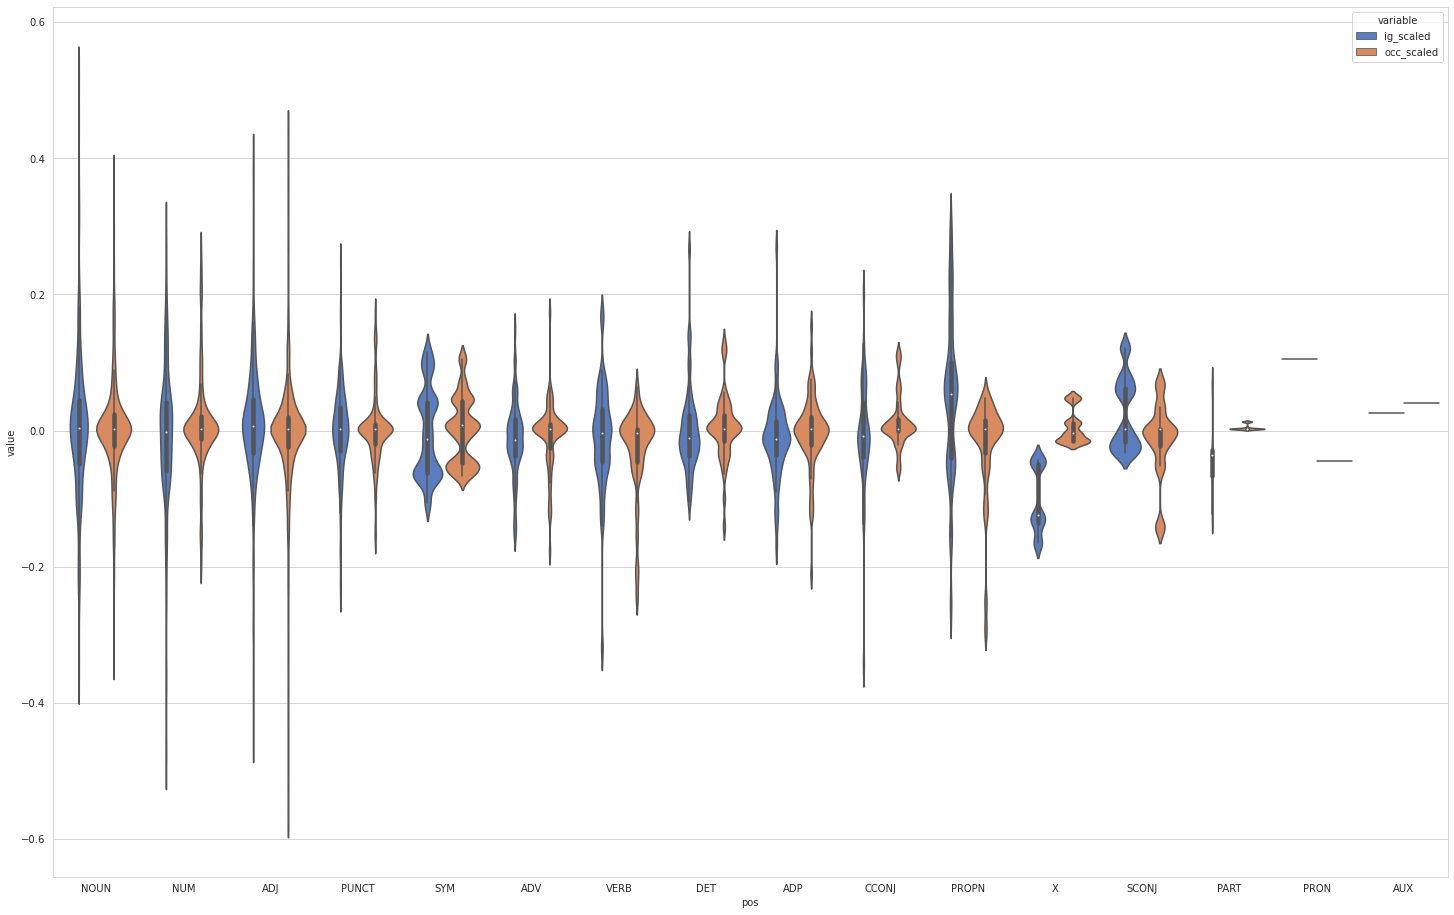

In [193]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(25, 16))
    ax = sns.violinplot(x="pos", y="value", hue="variable",
                        data=df_melt, 
                        palette="muted", 
                        split=False,
                        #inner="quartile",
                        bw=.2)

In [194]:
# Sort the values
mean_values = [(column, float(df_melt[df_melt['pos'] == column].mean())) for column in df['pos'].unique()]
mean_values.sort(key = lambda x : (x[1]))

sorter = [pos_value for (pos_value, mean) in mean_values]
#print(sorter)

In [195]:
df_melt_sorted = df_melt.set_index('pos')
df_melt_sorted = df_melt_sorted.loc[sorter]
df_melt_sorted['pos'] = df_melt_sorted.index

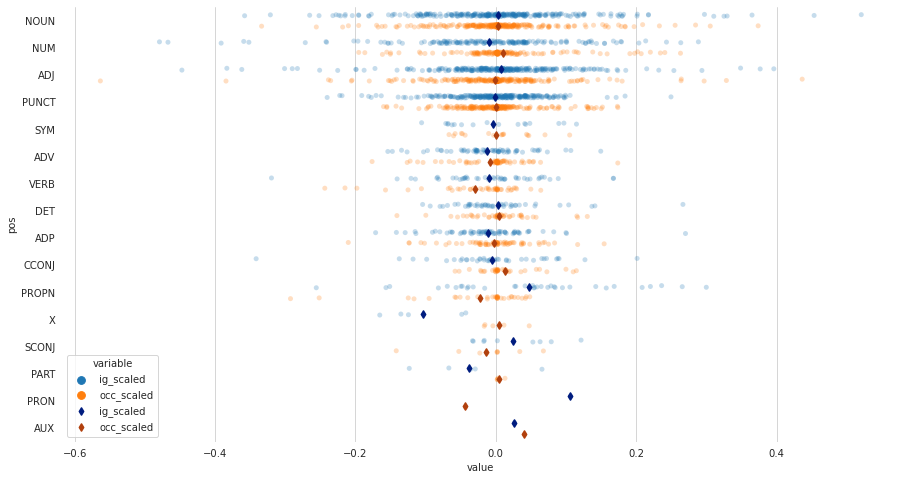

In [196]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 8))
    # Initialize the figure
    #f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(x="value", y="pos", hue="variable",
                  data=df_melt, dodge=True, alpha=.25, zorder=1)

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(x="value", y="pos", hue="variable",
                  data=df_melt, dodge=.4,
                  join=False, palette="dark",
                  markers="d", scale=.75, ci=None)

    # Improve the legend
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[3:], labels[3:], title="gradients",
    #          handletextpad=0, columnspacing=1,
    #          loc="lower right", ncol=3, frameon=True)

In [45]:
# Sort the values
mean_values = [(column, float(df_highest_melt[df_highest_melt['pos'] == column].mean())) for column in df_highest['pos'].unique()]
mean_values.sort(key = lambda x : (x[1]))

sorter = [pos_value for (pos_value, mean) in mean_values]

df_melt_sorted = df_highest_melt.set_index('pos')
df_melt_sorted = df_melt_sorted.loc[sorter]
df_melt_sorted['pos'] = df_melt_sorted.index

'\nwith sns.axes_style("whitegrid"):\n    f, ax = plt.subplots(figsize=(25, 16))\n    ax = sns.violinplot(x="pos", y="value", #hue="variable",\n                        data=df_highest_melt, \n                        palette="muted", \n                        #split=True,\n                        inner="quartile",\n                        bw=.2)\n'

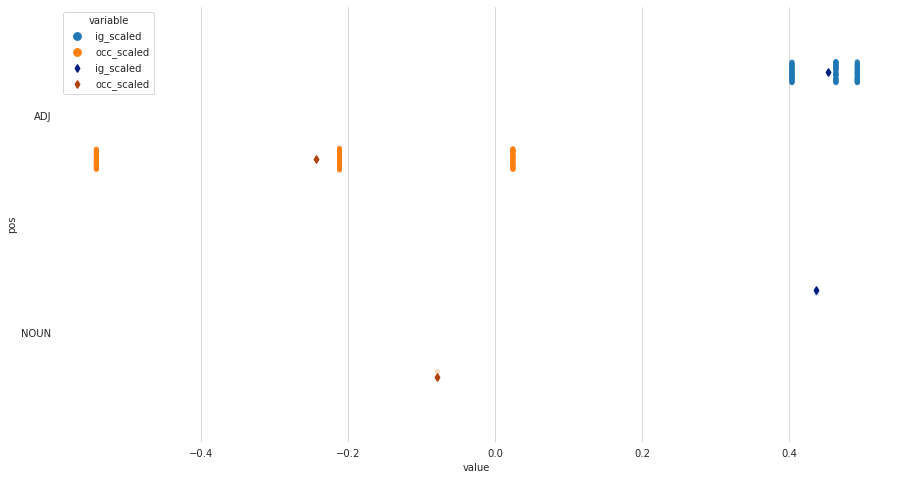

In [67]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 8))
    # Initialize the figure
    #f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(x="value", y="pos", hue="variable",
                  data=df_melt_sorted, dodge=True, alpha=.25, zorder=1)

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(x="value", y="pos", hue="variable",
                  data=df_melt_sorted, dodge=.4,
                  join=False, palette="dark",
                  markers="d", scale=.75, ci=None)


'''
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(25, 16))
    ax = sns.violinplot(x="pos", y="value", #hue="variable",
                        data=df_highest_melt, 
                        palette="muted", 
                        #split=True,
                        inner="quartile",
                        bw=.2)
'''

# Stats

In [90]:
from scipy import stats 
import pylab 

In [119]:
a = df[df['pos'] == 'NOUN']['ig_scaled']
b = df[df['pos'] == 'PUNCT']['ig_scaled']
c = df[df['pos'] == 'ADJ']['ig_scaled']

In [99]:
stats.ttest_1samp(a, 0, nan_policy='propagate', alternative='two-sided')

Ttest_1sampResult(statistic=1.1812059130238075, pvalue=0.23781500662089633)

In [110]:
stats.ttest_1samp(b, 0, nan_policy='propagate', alternative='less')

Ttest_1sampResult(statistic=1.9374935116410963, pvalue=0.9735121762496016)

In [105]:
stats.ttest_ind(a, b)

Ttest_indResult(statistic=0.1830259072759498, pvalue=0.8547969848004462)

(array([  2.,   0.,   0.,   1.,   1.,   1.,   1.,   2.,   4.,   6.,   2.,
          5.,  12.,  12.,  15.,  30.,  62.,  84., 167., 186., 136.,  88.,
         37.,  32.,  19.,   8.,   9.,   3.,   6.,   3.,   2.,   5.,   1.,
          1.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([-0.46483842, -0.44091267, -0.41698693, -0.39306118, -0.36913543,
        -0.34520968, -0.32128393, -0.29735818, -0.27343244, -0.24950669,
        -0.22558094, -0.20165519, -0.17772944, -0.1538037 , -0.12987795,
        -0.1059522 , -0.08202645, -0.0581007 , -0.03417495, -0.01024921,
         0.01367654,  0.03760229,  0.06152804,  0.08545379,  0.10937953,
         0.13330528,  0.15723103,  0.18115678,  0.20508253,  0.22900828,
         0.25293402,  0.27685977,  0.30078552,  0.32471127,  0.34863702,
         0.37256277,  0.39648851,  0.42041426,  0.44434001,  0.46826576,
         0.49219151]),
 <BarContainer object of 40 artists>)

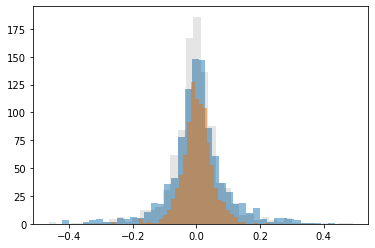

In [147]:
plt.hist(a, bins=40, alpha=.5)
plt.hist(b, bins=40, alpha=.5)
plt.hist(c, bins=40, alpha=.1, color='black')

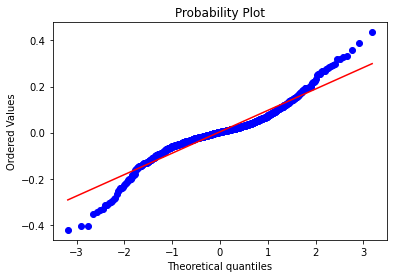

In [115]:
stats.probplot(a, dist="norm", plot=pylab)
pylab.show()

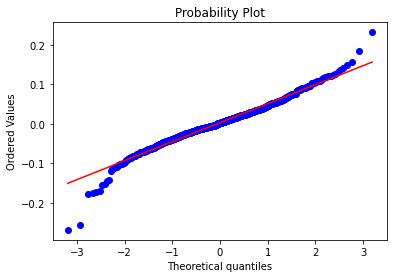

In [116]:
stats.probplot(b, dist="norm", plot=pylab)
pylab.show()

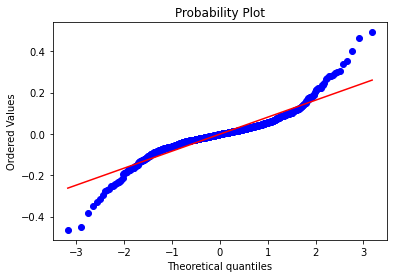

In [122]:
stats.probplot(c, dist="norm", plot=pylab)
pylab.show()